<a href="https://colab.research.google.com/github/BehnamLatifi/Sample-Project/blob/main/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

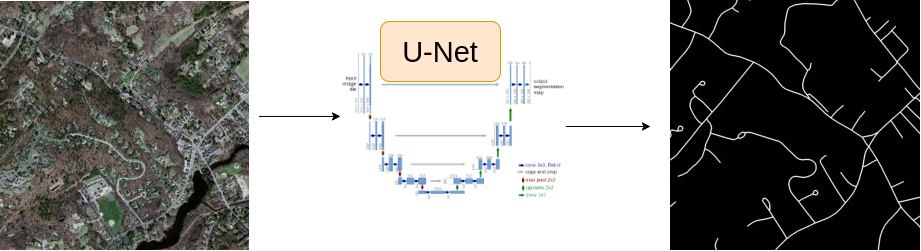

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 2

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

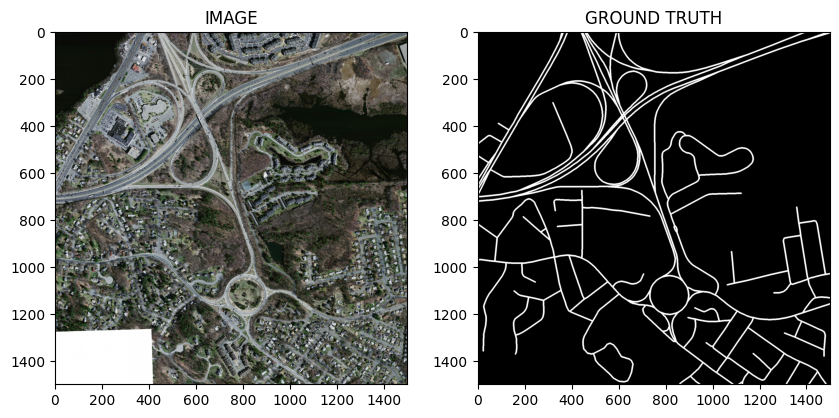

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray');

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [ ]:
len(train_df)

159

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class segmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1) # (h, w, c)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) #(c, h, w)

    image = torch.Tensor(image) / 255.
    mask = torch.round(torch.Tensor(mask) / 255.)

    return image, mask


In [ ]:
trainset = segmentationDataset(train_df, get_train_augs())
validset = segmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


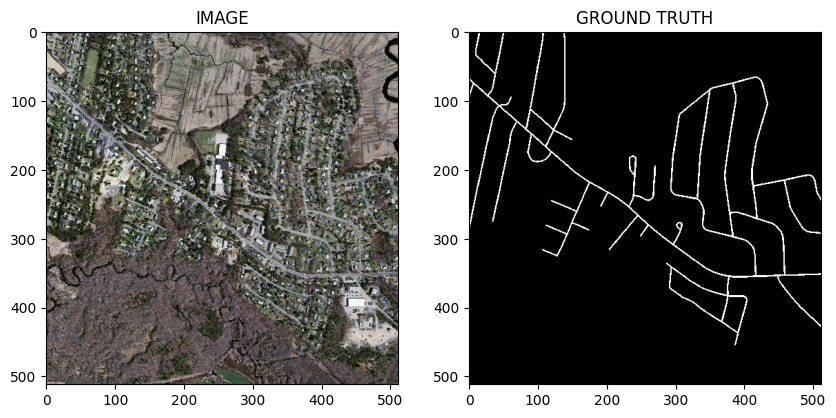

In [ ]:
idx = 21

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f'Total number of batches in trainloader : {len(trainloader)}')
print(f'Total number of batches in validloader : {len(validloader)}')

Total number of batches in trainloader : 20
Total number of batches in validloader : 5


In [ ]:
for images, masks in trainloader:
  print(f'One batch image shape : {images.shape}')
  print(f'One batch mask shape : {masks.shape}')
  break;

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.backbone(images)
    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(dataloader, model, optimizer):
  model.train() # Turn ON dropout, batchnorm, etc...
  total_loss = 0.
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(dataloader, model):
  model.eval() # Turn OFF dropout, batchnorm, etc...
  total_loss = 0.
  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()
  return total_loss / len(dataloader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)
  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'best-model.pt')
    print('SAVED-MODEL')
    best_loss = valid_loss
  print(f'Epoch : {i + 1} Train Loss : {train_loss} Valid Loss : {valid_loss}')

100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


SAVED-MODEL
Epoch : 1 Train Loss : 1.0271664321422578 Valid Loss : 0.9982351779937744


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED-MODEL
Epoch : 2 Train Loss : 0.7488876283168793 Valid Loss : 0.8189441680908203


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


SAVED-MODEL
Epoch : 3 Train Loss : 0.7096745401620865 Valid Loss : 0.7474542617797851


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 4 Train Loss : 0.680661740899086 Valid Loss : 0.7684316992759704


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


SAVED-MODEL
Epoch : 5 Train Loss : 0.6606844544410706 Valid Loss : 0.7091060757637024


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


SAVED-MODEL
Epoch : 6 Train Loss : 0.6444080144166946 Valid Loss : 0.6955304503440857


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


SAVED-MODEL
Epoch : 7 Train Loss : 0.6360228538513184 Valid Loss : 0.6743127226829528


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch : 8 Train Loss : 0.6309980630874634 Valid Loss : 0.7150158166885376


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


SAVED-MODEL
Epoch : 9 Train Loss : 0.6174690008163453 Valid Loss : 0.6567630648612977


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch : 10 Train Loss : 0.6525175988674163 Valid Loss : 0.9755269527435303


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch : 11 Train Loss : 0.6484257102012634 Valid Loss : 0.6660747051239013


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch : 12 Train Loss : 0.6220191895961762 Valid Loss : 0.6584538102149964


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch : 13 Train Loss : 0.605621549487114 Valid Loss : 0.6846024870872498


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch : 14 Train Loss : 0.6051189869642257 Valid Loss : 0.6520210027694702


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED-MODEL
Epoch : 15 Train Loss : 0.6089226752519608 Valid Loss : 0.6466890692710876


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch : 16 Train Loss : 0.5923882305622101 Valid Loss : 0.6610329747200012


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch : 17 Train Loss : 0.5826931655406952 Valid Loss : 0.6265491843223572


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch : 18 Train Loss : 0.5923342168331146 Valid Loss : 0.6996265888214112


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch : 19 Train Loss : 0.5899909704923629 Valid Loss : 0.6674005389213562


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch : 20 Train Loss : 0.5840212628245354 Valid Loss : 0.6520318388938904


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch : 21 Train Loss : 0.5759268015623092 Valid Loss : 0.6330958127975463


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch : 22 Train Loss : 0.5711958825588226 Valid Loss : 0.6326589584350586


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch : 23 Train Loss : 0.5674606144428254 Valid Loss : 0.6553582549095154


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch : 24 Train Loss : 0.5685724169015884 Valid Loss : 0.6234629631042481


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

Epoch : 25 Train Loss : 0.5654242217540741 Valid Loss : 0.6596768140792847


# Task 9 : Inference

In [ ]:
idx = 30

model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.

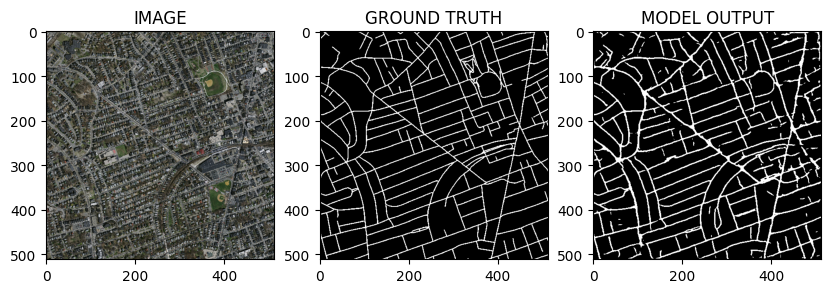

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

